<a href="https://colab.research.google.com/github/Arvind-55555/Air-Quality-in-Hyderabad/blob/main/openaq_air_quality_analysis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OpenAQ Air Quality Analysis (Colab)
This notebook is configured to use the **local sample snapshot** `data/sample_air_quality_IN.json` by default.

In [4]:
# Install Spark / dependencies. This cell is cross-platform:
# - In Colab/Linux we keep the original apt/wget/tar steps.
# - On local Windows/macOS/Linux, we install the pyspark wheel and findspark via pip (pyspark bundles Spark).
import platform, sys, os
is_colab = os.path.exists('/content') or 'google.colab' in sys.modules
if is_colab and platform.system() == 'Linux':
    # Colab-specific install (leave as-is for Colab notebooks)
    !apt-get install openjdk-11-jdk-headless -qq > /dev/null
    !wget -q https://downloads.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz
    !tar xf spark-3.5.6-bin-hadoop3.tgz
    !pip install -q findspark requests pandas matplotlib
else:
    # Local environment (Windows / macOS / Linux): install pyspark + helpers via pip
    import subprocess
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip'])
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pyspark', 'findspark', 'requests', 'pandas', 'matplotlib'])

In [6]:
import os, json
# Placeholder - paste your API key here if you want live fetch (optional)
os.environ['OPENAQ_API_KEY'] = 'your_api_key_here'
from datetime import datetime
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'
os.environ['SPARK_HOME'] = '/content/spark-3.5.6-bin-hadoop3'
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('OpenAQ-Colab').getOrCreate()
print('Spark version:', spark.version)

Spark version: 3.5.6


In [12]:
# Load sample local snapshot (fallback behavior)
from google.colab import userdata
userdata.get('OPENAQ_API_KEY')
with open('/content/sample_air_quality_IN.json','r') as f:
    data = json.load(f)
records = data.get('results', [])
rdd = spark.sparkContext.parallelize(records)
df = spark.read.json(rdd)
print('Schema:')
df.printSchema()
df.show(5)


Schema:
root
 |-- city: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: string (nullable = true)
 |-- date: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- location: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: double (nullable = true)

+------+--------------------+-------+--------------------+---------------+---------+-----+------+
|  city|         coordinates|country|                date|       location|parameter| unit| value|
+------+--------------------+-------+--------------------+---------------+---------+-----+------+
| Delhi|{22.138726, 86.70...|     IN|{2025-10-30T09:53...| Delhi Sensor 3|       co|mg/m³|  1.16|
| Delhi|{25.125061, 80.92...|     IN|{2025-10-30T07:21...| Delhi Sensor 5|      no2|µg/m³|131.92|
| Delhi|{15.706

In [13]:
# Clean & pivot (simple)
from pyspark.sql.functions import col, to_timestamp
df2 = df.select(col('city'), col('country'), col('parameter'), col('value').cast('double'), col('date.utc').alias('timestamp'))
df2 = df2.filter(col('value').isNotNull())
df2 = df2.withColumn('timestamp', to_timestamp('timestamp'))
pivoted = df2.groupBy('city','country','timestamp').pivot('parameter').avg('value')
pivoted.show(10)


+---------+-------+--------------------+----+------+----+-----+------+-----+
|     city|country|           timestamp|  co|   no2|  o3| pm10|  pm25|  so2|
+---------+-------+--------------------+----+------+----+-----+------+-----+
|Bengaluru|     IN|2025-10-29 23:40:...|NULL|  NULL|NULL|73.22|  NULL| NULL|
|    Delhi|     IN|2025-10-30 09:53:...|1.16|  NULL|NULL| NULL|  NULL| NULL|
|   Mumbai|     IN|2025-10-30 00:54:...|NULL|  NULL|NULL| NULL|255.05| NULL|
|  Chennai|     IN|2025-10-30 01:43:...|0.64|  NULL|NULL| NULL|  NULL| NULL|
|    Delhi|     IN|2025-10-30 07:21:...|NULL|131.92|NULL| NULL|  NULL| NULL|
|Hyderabad|     IN|2025-10-30 00:29:...|1.01|  NULL|NULL| NULL|  NULL| NULL|
|  Kolkata|     IN|2025-10-30 00:03:...|NULL|  NULL|NULL| NULL| 25.23| NULL|
|Hyderabad|     IN|2025-10-30 05:05:...|NULL| 84.82|NULL| NULL|  NULL| NULL|
|  Kolkata|     IN|2025-10-30 06:35:...|NULL|  NULL|NULL| NULL|  NULL|77.93|
|  Chennai|     IN|2025-10-30 06:32:...|NULL|  NULL|NULL| NULL| 220.8| NULL|

In [14]:
# Simple AQI categorization and city aggregation
from pyspark.sql.functions import when
df_aqi = pivoted.withColumn('AQI_Level', when(col('pm25') <= 50, 'Good').when(col('pm25') <= 100, 'Moderate').when(col('pm25') <= 200, 'Unhealthy').when(col('pm25') <= 300, 'Very Unhealthy').otherwise('Hazardous'))
city_avg = df_aqi.groupBy('city').avg('pm25').orderBy('avg(pm25)', ascending=False)
city_avg.show()


+---------+---------+
|     city|avg(pm25)|
+---------+---------+
|   Mumbai|   255.05|
|  Chennai|    220.8|
|   Jaipur|   147.61|
|  Kolkata|    25.23|
|     Pune|     NULL|
|    Delhi|     NULL|
|Bengaluru|     NULL|
|Hyderabad|     NULL|
+---------+---------+



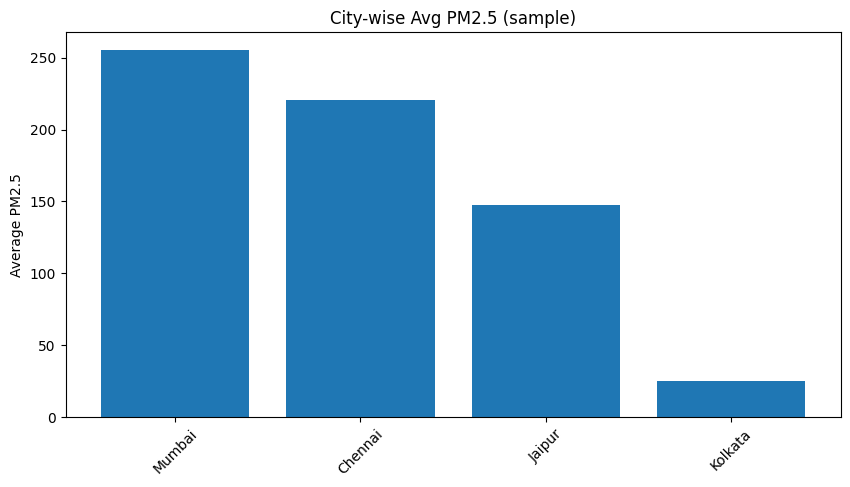

In [15]:
# Convert to Pandas for plotting
import matplotlib.pyplot as plt
pandas_df = city_avg.toPandas()
if not pandas_df.empty:
    plt.figure(figsize=(10,5))
    plt.bar(pandas_df['city'], pandas_df['avg(pm25)'])
    plt.xticks(rotation=45)
    plt.ylabel('Average PM2.5')
    plt.title('City-wise Avg PM2.5 (sample)')
    plt.show()
